In [1]:
import copy
import extra_functions as xf
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import time

from scipy.stats import binom, hypergeom
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline


## I. Data cleaning and feature engineering

### 1. Import dataset downloaded from Kaggle and create time-related features

In [2]:
df = pd.read_csv('data/cab_rides.csv')

In [3]:
df['day']=df.time_stamp.apply(lambda x: time.strftime('%a', time.localtime(x/1000)))
df['AMPM']=df.time_stamp.apply(lambda x: time.strftime('%p', time.localtime(x/1000)))
df['month']=df.time_stamp.apply(lambda x: time.strftime('%b', time.localtime(x/1000)))
df['time']=df.time_stamp.apply(lambda x: time.strftime('%H', time.localtime(x/1000)))
df['week']=df.time_stamp.apply(lambda x: time.strftime('%U', time.localtime(x/1000)))
df['date_time']=df.time_stamp.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x/1000)))


### 2. Create variable as key for merging with a weather data set

In [4]:
df['merge_date'] = df.source.astype(str) +" - "+ df.date_time.astype("str") 
df1 = pd.read_csv('data/weather.csv')
df1['date_time']=df1.time_stamp.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x)))
#create a variable with time and location for merging
df1['merge_date'] = df1.location.astype(str) +" - "+ df1.date_time.astype("str") 
merged_df = df.merge(df1, how='inner', left_on = ['merge_date'], right_on=['merge_date'], suffixes=('_c','_w'))
merged_df.head()

,distance,cab_type,time_stamp_c,destination,source,price,surge_multiplier,id,product_id,name,...,merge_date,temp,location,clouds,pressure,rain,time_stamp_w,humidity,wind,date_time_w
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
1,1.33,Lyft,1544952309308,Beacon Hill,Haymarket Square,7.0,1.0,0d468502-34b5-447f-be9f-acbb62176072,lyft,Lyft,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
2,0.53,Lyft,1544951109578,North Station,Haymarket Square,27.5,1.0,2aa8d17e-4b13-4200-87db-db3eed73ca6b,lyft_luxsuv,Lux Black XL,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
3,2.36,Lyft,1544954108860,Back Bay,Haymarket Square,7.0,1.0,4944c164-0463-47b9-96e1-15ffe8b9c7c9,lyft_line,Shared,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
4,0.62,Uber,1544954108161,West End,Haymarket Square,10.5,1.0,b1c23003-39fb-4030-9961-4f3420b23907,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04


### 3. Further cleaning of the merged dataframe and create additional features that might have predictive power

In [5]:
# drop duplicates
merged_df.drop_duplicates(subset='id', keep='first', inplace=True)


In [6]:
merged_df['time'] = merged_df['time'].astype(int)

In [7]:
merged_df['rushhr'] = 0
merged_df.loc[(merged_df.time > 7) & (merged_df.time < 10), 'rushhr'] = 1
merged_df.loc[(merged_df.time > 17) & (merged_df.time < 22), 'rushhr'] = 1

In [8]:
#one hot encoding all the categorical variables
merged_df = pd.get_dummies(merged_df, columns=[
                           'cab_type', 'destination', 'source', 'name', 'day', 'AMPM', 'month', 'week'])

In [9]:
merged_df['wkndPM']=0
merged_df.loc[(merged_df.day_Fri == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
merged_df.loc[(merged_df.day_Sat == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
merged_df.loc[(merged_df.day_Sun == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
wkndPMdf = merged_df.groupby('merge_date')['wkndPM'].sum()

In [10]:
merged_df['Black'] = 0
merged_df['Black'] = merged_df['name_Black'] + merged_df['name_Black SUV'] + \
    merged_df['name_Lux Black'] + merged_df['name_Lux Black XL']

In [11]:
merged_df['base_price'] = merged_df.price/merged_df.surge_multiplier

In [12]:
merged_df['sports'] = 0
#A sport event dummy that equals 1 when a major sport team in the city has a game that day (Patriots, Celtics, Bruins)
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-02')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-11-30')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-06')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-10')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-14')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-11-29')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-01')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-08')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-11')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-16')) & (merged_df.AMPM_PM == 1), 'sports'] = 1

In [13]:
sportdf = merged_df.groupby('date_time_c')['sports'].sum()

In [14]:
# log-transforming all numerical variables
names = ['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'base_price', 'surge_multiplier']
for n in names:
    merged_df[f'l{n}'] = np.log(merged_df[n])

/Users/anthonyschams/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


### 4. Drop rows with nan values and clean the nan values in the rain variable

In [15]:
merged_df.rain.fillna(0, inplace= True)
merged_df['rain_d']=0

merged_df.loc[(merged_df.rain) > 0, 'rain_d'] = 1

merged_df.dropna(inplace=True)

merged_df.drop(['time_stamp_c', 'time_stamp_w', 'date_time_c',
                'date_time_w', 'id', 'product_id'], axis=1, inplace=True)

merged_df.drop(['lrain', 'lclouds'], axis=1, inplace=True)

# save cleaned dataset locally
merged_df.to_csv('data/merged_df_Tues.csv')

## II. Visualization

### 1. Visually inspect each feature to identify non-normal distributions, collinearity, etc.

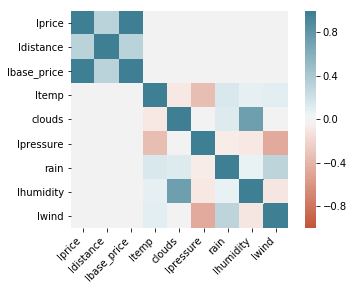

In [16]:
corr = merged_df[['lprice', 'ldistance','lbase_price','ltemp','clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## III. Linear Regression

##  Feature selection with Random Forest
### After several failed attempts at identifying a model with normal residuals and good predictive power, we decided to use random forest to help with feature selection.

In [17]:
dataSet_df = merged_df[['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 
                        'rain', 'humidity', 'wind', 'name_Black', 'name_Black SUV', 
                        'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 
                        'name_Lyft XL', 'name_Shared', 'name_Taxi', 'name_UberPool', 'name_UberX', 
                        'name_UberXL', 'name_WAV', 'destination_Back Bay', 'destination_Beacon Hill', 
                        'destination_Boston University', 'destination_Fenway', 'destination_Financial District',
                        'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 
                        'destination_Northeastern University', 'destination_South Station', 
                        'destination_Theatre District', 'destination_West End', 'source_Back Bay', 
                        'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
                        'source_Financial District', 'source_Haymarket Square',
                        'source_North End', 'source_North Station',
                        'source_Northeastern University', 'source_South Station',
                         'source_Theatre District', 'source_West End','price']]
XX= dataSet_df[['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 
                'rain', 'humidity', 'wind', 'name_Black', 'name_Black SUV', 
                'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 
                'name_Lyft XL', 'name_Shared', 'name_Taxi', 'name_UberPool', 'name_UberX', 
                'name_UberXL', 'name_WAV', 'destination_Back Bay', 'destination_Beacon Hill', 
                'destination_Boston University', 'destination_Fenway', 'destination_Financial District',
                'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 
                'destination_Northeastern University', 'destination_South Station', 
                'destination_Theatre District', 'destination_West End', 'source_Back Bay', 
                'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
                'source_Financial District', 'source_Haymarket Square',
                'source_North End', 'source_North Station',
                'source_Northeastern University', 'source_South Station',
                'source_Theatre District', 'source_West End']]
YY = dataSet_df['price']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(XX.values, YY.values, test_size=0.33, random_state=42)

In [19]:
regr2 = RandomForestRegressor(max_depth=5, random_state=137, n_estimators=2000)
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
           oob_score=False, random_state=137, verbose=0, warm_start=False)

In [47]:
fimpDict2 = {}
for fimp in list(zip(XX.columns, regr2.feature_importances_)):
    fimpDict2.update({fimp[0]:fimp[1]})
kk = list(fimpDict2.keys())
vv = list(fimpDict2.values())


fimpDF = pd.DataFrame({'features':kk,
                      'importance':vv})
fimpDF.sort_values(by='importance', ascending=False)

,features,importance
9,name_Black SUV,3.151514e-01
12,name_Lux Black XL,3.090019e-01
11,name_Lux Black,1.116374e-01
0,distance,9.447521e-02
8,name_Black,8.849040e-02
10,name_Lux,4.902658e-02
1,surge_multiplier,3.201877e-02
34,source_Beacon Hill,1.012785e-04
33,source_Back Bay,5.207981e-05
4,pressure,9.760915e-06


### Features selected based on random forest model

#### Perform Lasso 

In [22]:
X3 = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 
       'cab_type_Uber', 'destination_Back Bay','source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d', 'Black']]
X3 = sm.add_constant(X3)
Y3 = merged_df['lprice']
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3,Y3, test_size = .2, random_state=42)

In [23]:
lasso3 = LassoCV()
lasso3.fit(X_train3, Y_train3)
preds3 = lasso3.predict(X_test3)
lasso3.coef_

/Users/anthonyschams/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 3.10131938e-01,  0.00000000e+00,  1.31332719e-03, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.63745944e-03,  1.17352035e+00,
       -1.84144393e-02, -2.81252810e-02, -5.15292163e-02,  0.00000000e+00,
        6.63898227e-03, -2.35667532e-02,  7.16724592e-03, -0.00000000e+00,
       -8.36625304e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.77479750e-01])

In [24]:
lasso3.score(X_test3, Y_test3)

0.6644156606613417

In [25]:
mse3 = mean_squared_error(Y_test3, preds3)
np.exp(mse3)

1.1136407986778565

In [26]:
np.exp(mse3)/np.exp(Y_test3).mean()

0.06743438927983081

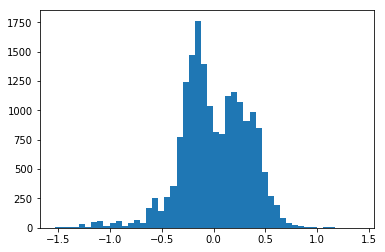

In [27]:
lasso3_res = Y_test3 - preds3
_ = plt.hist(lasso3_res, bins=50)

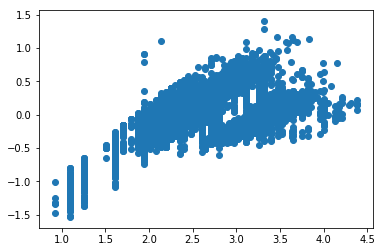

In [28]:
plt.scatter(Y_test3, lasso3_res)

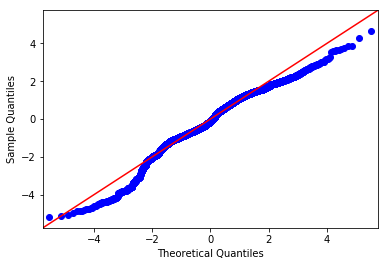

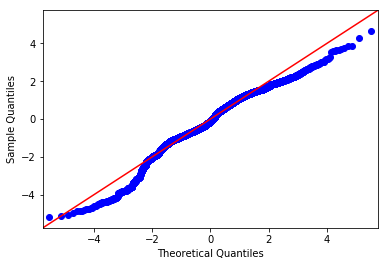

In [29]:
sm.qqplot(lasso3_res, stats.t, fit=True, line=str(45))

This model has the most normal residuals, decent scores (Adjusted R Sq. > 0.66) and relatively low MSE. It's the best linear fit for this data set.

## IV. Logistic Regression with Cross Validation

### Next, we'll try to predict the surge multiplier using a logistic model. Surge multiplier is encoded as 1 when it's over 1, and 0 otherwise.

In [30]:
X = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'cab_type_Lyft', 'destination_Back Bay',
       'destination_Boston University', 'surge_multiplier',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
       'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
       'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
       'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
       'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
       'week_49', 'sports', 'wkndPM']]
X = X[X.cab_type_Lyft == 1]

# X = sm.add_constant(X)
y = (X.surge_multiplier != 1).astype(int)
X.drop('surge_multiplier', axis=1, inplace=True)

In [31]:
#test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=24)

### Because the train set is quite large, the LogisticRegressionCV model took a very long time to run. The classes in this data set is also imbalanced (positive target ~3%). We decide to use a resampling technique (similar to bagging) by first separating the dataframe into observation with target equal 0 and 1, and sampling the exact amount of positive targets (~16k) from the subset with negative target to create a data frame with balanced classes.

In [32]:
mytrain = copy.deepcopy(X_train)
mytrain['y'] = y_train

In [33]:
features1 = ['ldistance','ltemp', 'clouds',
           'lpressure', 'rain', 'lhumidity', 'lwind',
           'cab_type_Lyft', 'destination_Back Bay',
           'destination_Boston University',
           'destination_Fenway', 'destination_Financial District',
           'destination_Haymarket Square', 'destination_North End',
           'destination_North Station', 'destination_Northeastern University',
           'destination_South Station', 'destination_Theatre District',
           'destination_West End', 'source_Back Bay', 
           'source_Boston University', 'source_Fenway',
           'source_Financial District', 'source_Haymarket Square',
           'source_North End', 'source_North Station',
           'source_Northeastern University', 'source_South Station',
           'source_Theatre District', 'source_West End', 'name_Black',
           'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
           'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
           'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
           'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
           'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
           'week_49', 'sports', 'wkndPM']

Xy1 = mytrain[mytrain['y'] == 1]
Xy0 = mytrain[mytrain['y'] == 0]

### We then fit the logistic regression with cross validation and L2 regularization 10 times and get the average.

In [34]:
lr_l2 = LogisticRegressionCV(penalty='l2', cv=5, solver='liblinear', n_jobs= -1)

0.6912970611121086 
 [[ 4.66967597e-02 -4.60834347e-01 -2.49685538e-01 -3.89715871e+01
   8.46814165e-01 -4.99147063e-01 -1.00209313e-01  9.71316432e+01
  -5.48648333e-03  8.34527985e+00  8.33649604e+00  1.47404629e-01
   8.20115349e+00  8.45505293e+00 -1.38810677e-01  8.24684805e+00
   8.52626621e+00  3.06349038e-03  1.33640583e-01  4.57565686e-01
   8.52540741e+00  8.55013971e+00 -6.76262286e-01  6.68936427e+00
   6.45013091e+00 -1.04914680e+00  8.73582644e+00  8.06967779e+00
   2.64657233e-01 -9.04416163e-01  0.00000000e+00  0.00000000e+00
   2.12395469e+01  2.13149619e+01  2.12765198e+01  2.12715581e+01
   2.11323285e+01 -9.10327215e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -7.22308679e-01 -4.53029307e-01
  -5.31471859e+00 -1.09442131e+00 -8.43499376e-01 -8.25251309e-01
  -3.76578860e-01  4.84480223e+01  4.86836208e+01 -5.44592294e-02
  -5.31471859e+00  8.61291193e-02  8.61291193e-02]]


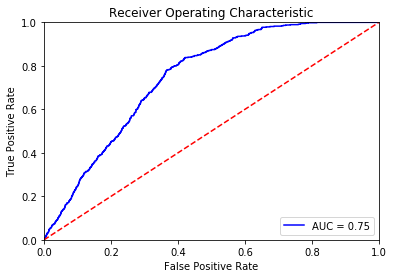

0.6855509666606812 
 [[ 4.98277444e-02 -3.20319947e-01  8.64774970e-02 -2.47823857e+01
   8.96606515e-01 -3.71121507e-01 -9.18491450e-02  6.18033606e+01
   4.13344180e-02  5.48312680e+00  5.37167734e+00  8.50780044e-02
   5.14781950e+00  5.52909030e+00 -1.25899956e-01  5.39940315e+00
   5.55267658e+00 -4.92437540e-02  6.79651608e-02  2.89913906e-01
   5.52829450e+00  5.60628510e+00 -6.69374462e-01  3.71779271e+00
   3.65771927e+00 -1.11736233e+00  5.72620833e+00  5.08326700e+00
   2.08532574e-01 -9.22331190e-01  0.00000000e+00  0.00000000e+00
   1.33484887e+01  1.33161004e+01  1.32893263e+01  1.34191982e+01
   1.32283112e+01 -4.79806418e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -7.81156952e-01 -2.86410541e-01
  -4.27593592e+00 -3.24951088e-01 -3.91650837e-01 -7.02392506e-01
  -1.67887678e-01  3.08419337e+01  3.09614269e+01 -2.25833758e-02
  -4.27593592e+00  8.35778330e-02  8.35778330e-02]]


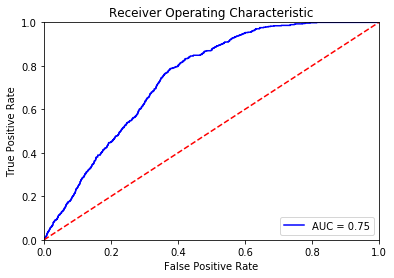

0.6875561142036272 
 [[ 2.54517444e-02 -9.41689724e-01 -2.29266430e-01 -4.48990983e+01
   9.87039579e-01 -8.90608343e-01 -1.19334845e-01  1.12543752e+02
  -1.32427388e-02  9.74168393e+00  9.58450388e+00  1.23639367e-01
   9.35228022e+00  9.79649277e+00 -1.55492075e-01  9.60669001e+00
   9.77719352e+00 -1.27654672e-02  1.62936087e-01  3.18469555e-01
   9.78298095e+00  9.83605999e+00 -5.73493360e-01  7.91095391e+00
   7.87259792e+00 -1.13225210e+00  9.95318798e+00  9.32912677e+00
   3.12724884e-01 -8.38007680e-01  0.00000000e+00  0.00000000e+00
   2.41839351e+01  2.42292356e+01  2.42200309e+01  2.42872296e+01
   2.41421580e+01 -8.51883741e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -8.16178153e-01 -4.81421462e-01
  -5.21300971e+00 -1.21140359e+00 -9.38241777e-01 -1.57520589e+00
  -3.84179551e-01  5.61131724e+01  5.64305795e+01  3.31094767e-02
  -5.21300971e+00  1.11205566e-01  1.11205566e-01]]


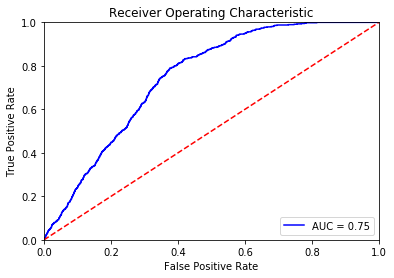

0.6898605374992518 
 [[ 4.16616931e-02 -5.39043822e-01 -4.06745575e-01 -4.10951263e+01
   1.52686545e+00 -5.66862208e-01 -1.00630663e-01  1.02584696e+02
  -1.10493743e-01  8.85993789e+00  8.68768792e+00 -1.31885539e-02
   8.70889379e+00  8.88714171e+00 -2.22087745e-01  8.68494460e+00
   8.90749597e+00 -1.68369047e-01  3.95393521e-02  3.67743911e-01
   9.02077653e+00  8.98866354e+00 -7.27013784e-01  7.09568859e+00
   7.09590736e+00 -1.14222843e+00  9.19234853e+00  8.45520919e+00
   2.18041744e-01 -9.07249439e-01  0.00000000e+00  0.00000000e+00
   2.22281327e+01  2.22989384e+01  2.23220650e+01  2.23535955e+01
   2.22118346e+01 -8.82987058e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -6.81425387e-01 -4.09801061e-01
  -5.15377525e+00 -1.09858787e+00 -7.62583328e-01 -7.43527248e-01
  -4.43193673e-01  5.11774744e+01  5.14072212e+01 -1.34547133e-03
  -5.15377525e+00  1.57662061e-01  1.57662061e-01]]


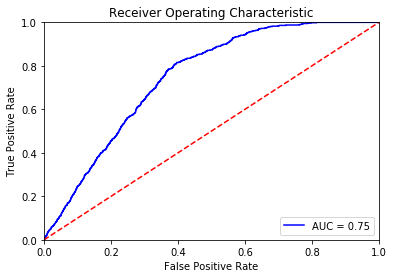

0.6839947327467528 
 [[-3.89243534e-04 -1.06818281e-02 -1.04861198e-01 -7.25427788e-02
   5.51218281e-01  1.45982023e-01 -7.43487229e-03  2.36926707e-03
  -2.84828880e-02  2.44179162e-01  1.17133958e-01  9.28019323e-02
   2.37669991e-02  3.57972576e-01 -1.08879955e-01  1.28784701e-01
   3.47440089e-01  1.62238728e-02  1.39545189e-01  3.81485942e-01
   3.76993597e-01  5.04305281e-01 -5.09916270e-01 -1.38782000e+00
  -1.31250746e+00 -9.28167991e-01  6.71799872e-01 -6.96795041e-02
   3.01777117e-01 -7.90465671e-01  0.00000000e+00  0.00000000e+00
   6.20776266e-01  6.85066550e-01  6.96581383e-01  6.89428514e-01
   5.54198599e-01 -3.24368204e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.80202283e-01 -5.61181425e-03
  -3.09213361e-01  1.41257069e-01  2.66573925e-01  2.82029440e-01
   2.89250212e-02  3.79603404e-02 -3.55910734e-02  1.04376243e-01
  -3.09213361e-01  5.49499647e-02  5.49499647e-02]]


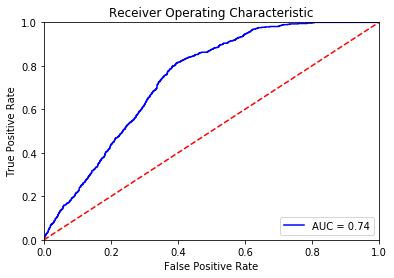

0.682169150655414 
 [[-7.97441376e-03 -1.45837477e+00 -2.05366856e-01 -4.32017191e+01
   1.10820161e+00 -1.01158285e+00 -5.11443277e-02  1.08936513e+02
  -6.44713308e-02  9.31643822e+00  9.18801361e+00  1.05329474e-01
   9.02834511e+00  9.40152983e+00 -2.42287973e-01  9.22303088e+00
   9.47936769e+00 -1.10259049e-01  1.10391193e-01  4.58742452e-01
   9.52995544e+00  9.56094720e+00 -5.62044112e-01  7.64690835e+00
   7.71088986e+00 -9.47887670e-01  9.75774433e+00  9.09334249e+00
   2.67335554e-01 -8.25148084e-01  0.00000000e+00  0.00000000e+00
   2.35570269e+01  2.36376276e+01  2.35524531e+01  2.36026279e+01
   2.35270391e+01 -8.94026153e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.04994020e+00 -4.96666267e-01
  -5.10820739e+00 -1.46243808e+00 -1.03502112e+00 -1.09083216e+00
  -4.67886144e-01  5.42132156e+01  5.47232974e+01  1.62611893e-01
  -5.10820739e+00  1.73035598e-01  1.73035598e-01]]


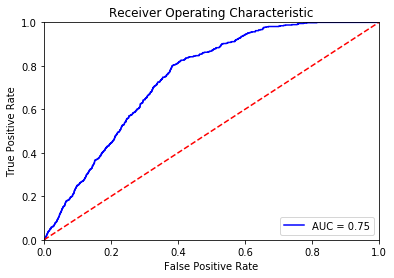

0.6879751002573772 
 [[-1.92805637e-02 -3.79621763e-01 -4.62987302e-01 -4.24751986e+01
   1.12533253e+00 -3.68393958e-01 -2.00353831e-01  1.05960961e+02
  -1.22900851e-02  9.18536880e+00  9.05535622e+00  1.66806567e-01
   8.86385961e+00  9.26869036e+00 -1.60220130e-01  8.99816642e+00
   9.17650984e+00 -5.01059972e-02  2.08623817e-01  3.64336137e-01
   9.30335966e+00  9.30870575e+00 -6.45838445e-01  7.25061136e+00
   7.39273406e+00 -9.97024838e-01  9.41461330e+00  8.74298596e+00
   2.26937680e-01 -9.63061932e-01  0.00000000e+00  0.00000000e+00
   2.28460601e+01  2.28989605e+01  2.29042092e+01  2.29238377e+01
   2.27985944e+01 -8.41070047e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -6.82800866e-01 -6.04108338e-01
  -5.33011006e+00 -9.99262314e-01 -8.63635279e-01 -1.40760878e+00
  -1.70477030e-01  5.29449141e+01  5.30160473e+01 -1.89746413e-01
  -5.33011006e+00 -4.09003329e-02 -4.09003329e-02]]


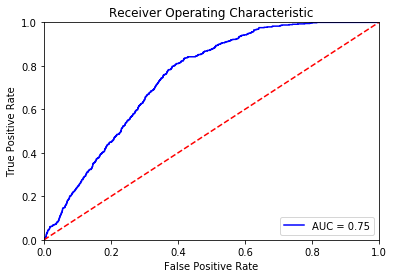

0.6919255401927336 
 [[-5.41597972e-02 -1.01922934e+00 -8.52894185e-02 -5.20347866e+01
   1.23845683e+00 -9.04619201e-01 -1.12479962e-01  1.30348167e+02
  -9.87356205e-02  1.12262277e+01  1.10768805e+01 -4.01916422e-02
   1.08393784e+01  1.11714987e+01 -3.28099114e-01  1.09809381e+01
   1.11186220e+01 -1.69247145e-01 -1.72093302e-02  4.00349967e-01
   1.13744096e+01  1.14352782e+01 -6.93486086e-01  9.41198772e+00
   9.29484857e+00 -1.09838640e+00  1.15495082e+01  1.08685890e+01
   2.67379618e-01 -8.84532672e-01  0.00000000e+00  0.00000000e+00
   2.78364339e+01  2.77637718e+01  2.78078796e+01  2.77891687e+01
   2.77176961e+01 -8.56678354e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -6.36773301e-01 -5.08685389e-01
  -5.06626181e+00 -9.39788808e-01 -1.03255435e+00 -9.15590396e-01
  -4.18345182e-01  6.49795969e+01  6.53685699e+01  1.36038211e-01
  -5.06626181e+00  1.40731435e-01  1.40731435e-01]]


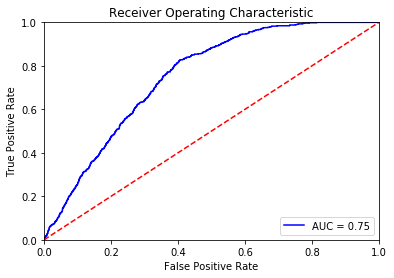

0.692643801999162 
 [[ 1.49184021e-02 -5.48585588e-01 -1.67680752e-01 -4.32663497e+01
   1.09796264e+00 -5.03329281e-01 -1.47477846e-01  1.07921954e+02
  -4.41848101e-02  9.33908657e+00  9.13856206e+00  2.72613087e-01
   9.00905228e+00  9.43572230e+00 -1.18425507e-01  9.17331866e+00
   9.39589135e+00 -9.84527422e-02  1.21644510e-01  3.70990717e-01
   9.39185665e+00  9.51863339e+00 -6.52182759e-01  7.38159444e+00
   7.55338665e+00 -1.13337255e+00  9.59934648e+00  8.98550298e+00
   2.56993633e-01 -9.21040109e-01  0.00000000e+00  0.00000000e+00
   2.33876990e+01  2.34392389e+01  2.34527502e+01  2.35076329e+01
   2.33222510e+01 -9.18761808e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.90406126e-01 -4.93709513e-01
  -5.38729844e+00 -6.78505080e-01 -8.01836421e-01 -1.14137233e+00
  -1.92879400e-01  5.39446002e+01  5.39773537e+01 -1.35536384e-01
  -5.38729844e+00 -4.02966261e-02 -4.02966261e-02]]


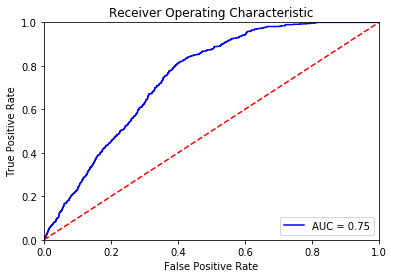

0.6866882145208595 
 [[ 1.15051721e-02 -5.72782005e-01 -3.09013284e-01 -3.29625203e+01
   1.09518968e+00 -5.06734096e-01 -1.24082531e-01  8.23071575e+01
   1.10135003e-01  7.18884102e+00  7.09137731e+00  1.58181233e-01
   6.91444087e+00  7.30442900e+00 -1.55508295e-01  7.04295749e+00
   7.34079159e+00  1.98857008e-02  3.06830244e-01  3.65201117e-01
   7.22230747e+00  7.30358477e+00 -6.85138852e-01  5.40578035e+00
   5.26373555e+00 -1.05487298e+00  7.49568219e+00  6.73322990e+00
   1.98242699e-01 -8.35531990e-01  0.00000000e+00  0.00000000e+00
   1.82874049e+01  1.82994752e+01  1.83086006e+01  1.83502130e+01
   1.81643817e+01 -9.10291799e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -7.14211760e-01 -2.88101970e-01
  -5.12428861e+00 -7.90732045e-01 -5.49467133e-01 -4.13659502e-01
  -3.02203233e-01  4.10427127e+01  4.12644448e+01  1.30259562e-01
  -5.12428861e+00  1.45530698e-01  1.45530698e-01]]


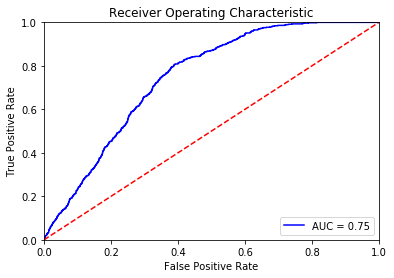

In [35]:
lrl2f16kcv5coef, lrl2f16kcv5score, lrl2f16kcv5pred = xf.baglr(lr_l2, Xy0, Xy1,X_test, y_test, features1, 16707, 10)

In [36]:
np.mean(lrl2f16kcv5score)

0.6879661219847968

### Because the average score from the two specifications are very similar (as shown in the full notebook), we chose to examine the model with L2 regularization because it ran faster.

In [ ]:
lrl2f16kcoef

In [ ]:
np.mean(lrl2f16kscore)

In [37]:
lr_l2 = LogisticRegressionCV(penalty='l2', cv=5, solver='liblinear', n_jobs= -1)
mySample1 = Xy1.sample(16707, replace=True, random_state=23456)
mySample = mySample1.append(Xy0.sample(16707, replace=True))
mySample.reset_index(inplace=True, drop=True)
y_sample = mySample['y']
x_sample = mySample[features1]
lr_l2.fit(x_sample, y_sample)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

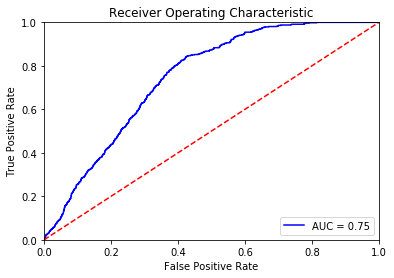

In [38]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr_l2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Normalized confusion matrix
[[0.57418562 0.42581438]
 [0.15826087 0.84173913]]
Confusion matrix, without normalization
[[4671 3464]
 [  91  484]]


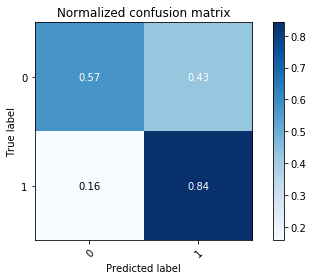

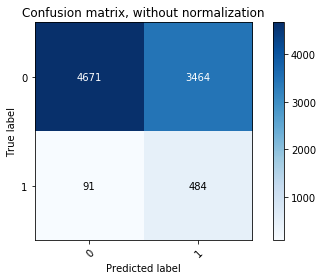

In [39]:
classnames = ['Surge', "Not Surge"]
preds2 = lr_l2.predict(X_test)
# Plot non-normalized confusion matrix
xf.plot_confusion_matrix(y_test, preds2, classnames,
                      normalize=True)
xf.plot_confusion_matrix(y_test, preds2, classnames)

## Time Series Analysis

In [40]:
Uber_avg_price = xf.get_avg_by_cab(df, 'Uber', 'date_time', 'price')
Lyft_avg_price = xf.get_avg_by_cab(df, 'Lyft', 'date_time', 'price')

Text(0.5,1,'Average Price of Ride')

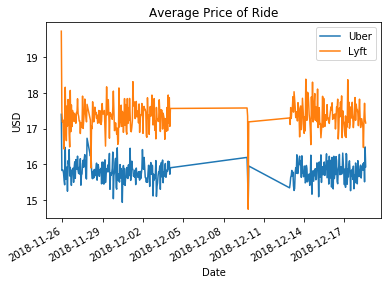

In [41]:
plt.figure()
Uber_avg_price.plot(label='Uber')
Lyft_avg_price.plot(label='Lyft')
plt.legend()
plt.xlabel('Date')
plt.ylabel('USD')
plt.title("Average Price of Ride")

We see that there is an extended period of time that contain no measurements. We will therefore subset our data to look at just this first segment of high activity.

Text(0.5,1,'Average Price of Ride')

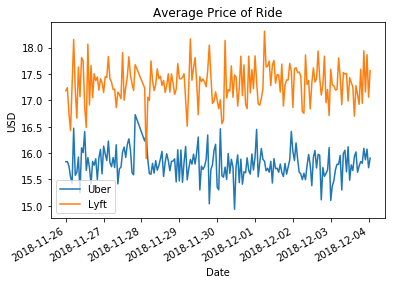

In [42]:
Uber_first_segment = Uber_avg_price['2018-11-26':'2018-12-04']
Lyft_first_segment = Lyft_avg_price['2018-11-26':'2018-12-04']

Uber_first_segment.plot(label='Uber')
Lyft_first_segment.plot(label='Lyft')
plt.legend()
plt.xlabel('Date')
plt.ylabel('USD')
plt.title("Average Price of Ride")

By inspection of the data, we have no reason to suspect that there is a trend or seasonality in it.

Text(0,0.5,'Correlation Value')

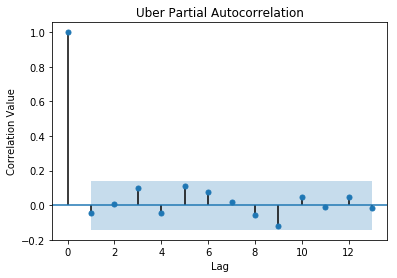

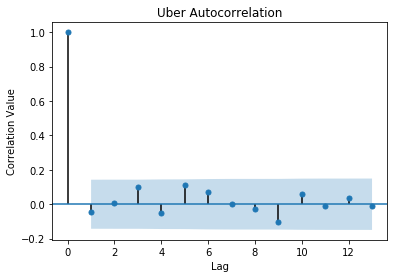

In [43]:
plot_pacf(Uber_first_segment, lags=np.floor(np.sqrt(len(Uber_first_segment))))
plt.title("Uber Partial Autocorrelation")
plt.xlabel('Lag')
plt.ylabel('Correlation Value')

plot_acf(Uber_first_segment, lags=np.floor(np.sqrt(len(Uber_first_segment))))
plt.title('Uber Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Correlation Value')

We see that there is no significant partial autocorrelation or autocorrelation in Uber's average ride price. This means that there is no autoregressive or moving average component to our data. This means that it is effectively random.

Text(0,0.5,'Correlation Value')

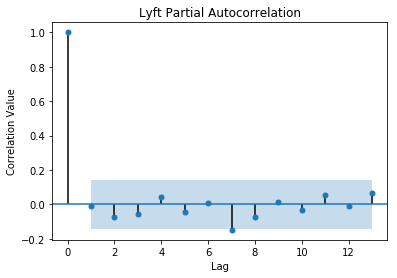

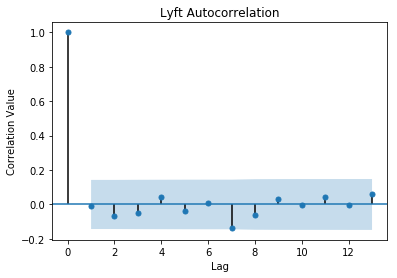

In [44]:
plot_pacf(Lyft_first_segment, lags=np.floor(np.sqrt(len(Lyft_first_segment))))
plt.title('Lyft Partial Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Correlation Value')

plot_acf(Lyft_first_segment, lags=np.floor(np.sqrt(len(Lyft_first_segment))))
plt.title('Lyft Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Correlation Value')

We see that there is no significant partial autocorrelation or autocorrelation for Lyft's average ride price either. This means that there is no autoregressive or moving average component to our data. This means that it is effectively random.
